# <font color='darkblue'>Vertical mode decomposition example</font>
Author: Wei-Ming Tsai, Unviersity of Miami, RSMAS<br>
Date: Mar, 2020


**[Haertel and Johnson, 1998, QJR. (HJ98)](https://rmets.onlinelibrary.wiley.com/doi/pdf/10.1002/qj.49712454611)** <br>
"Vertical mode decompositions break down atmospheric circulations into mathmetically separable components that are governed by shallow-water dynamics"

This notebook shows an example of applying vertical mode decompostions into real obseravations and the numerical method following Haertel and Johnson (1998). The derivation of equatons is sort of terrifying in the paper, but the numerical method is fairly easy to understand. 

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from warnings import filterwarnings

In [28]:
filterwarnings('ignore')

In [29]:
def vmode_plot(data):
    
    fig,ax = plt.subplots(1,3,figsize=(13,4))

    for n in range(3):
        ax[n].plot(data[:,n]/np.max(np.abs(data[:,n])),p_r/100,'k')
        ax[n].set_ylim([1000,100]);ax[n].set_xlim([-1.1,1.1])
        ax[n].vlines(x=0,ymin=100,ymax=1000,linewidth=0.6,linestyle=':')
        ax[n].set_xticks([-1,0,1])
        ax[n].set_ylabel('Pressure [hPa]',fontsize=12)
        ax[n].set_xlabel('Relative amplitude',fontsize=12)

    #ax[0].set_title('First mode');ax[1].set_title('Second mode');ax[2].set_title('Third mode');            
    plt.tight_layout()
    
    return ax

### 0 .Observatioanl data used: DYNAMO 
Get sounding data from [DYNAMO field campaign](http://johnson.atmos.colostate.edu/dynamo/products/array_averages/index.html) for decompostion of vetical modes.

In [30]:
os.chdir('/Users/willytsai/Desktop/')
data = xr.open_dataset('dynamo_nsa_v3a.nc')

In [31]:
T = data.T
theta = data.theta
Q1 = data.Q1
p = theta.level

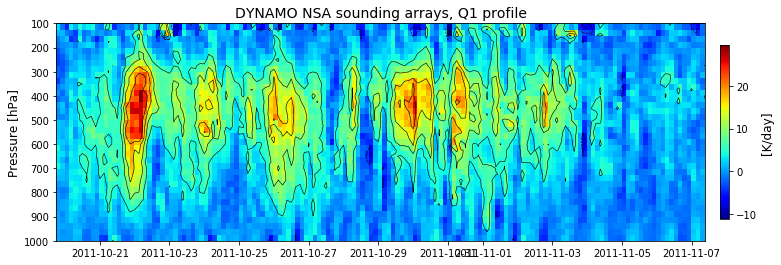

In [32]:
fig = plt.figure(figsize=(14,4))
Q1_sub = Q1[150:300]; theta_sub = theta[150:300]; T_sub = T[150:300]
time = Q1_sub.time
plt.pcolormesh(time.values,p,Q1_sub.T,cmap='jet');cbar = plt.colorbar(shrink=0.8,pad=0.02)
plt.contour(time.values,p,Q1_sub.T,levels=[-10,-5,5,10,15,20],colors=['k'],linewidths=0.6)
plt.ylim([1000,100])
cbar.set_label('[K/day]',fontsize=12)
plt.title('DYNAMO NSA sounding arrays, Q1 profile',fontsize=14);plt.ylabel('Pressure [hPa]',fontsize=12)
plt.show()

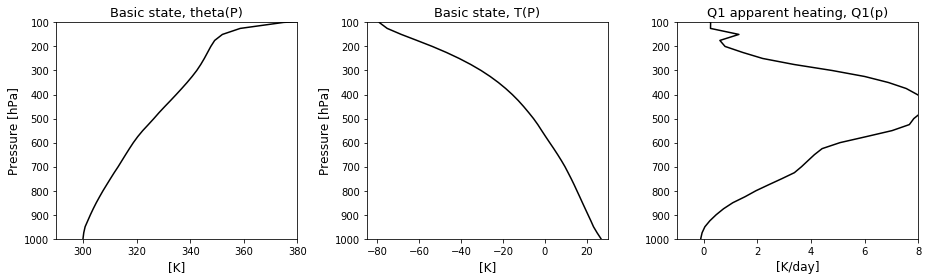

In [33]:
# get variables as the basic states 
fig,ax = plt.subplots(1,3,figsize=(13,4))
theta_bar = np.nanmean(theta_sub,axis=0)
ax[0].plot(theta_bar,p,'k');
ax[0].set_xlim([290,380]);ax[0].set_ylim(([1000,100]))
ax[0].set_xlabel('[K]',fontsize=12);ax[0].set_ylabel('Pressure [hPa]',fontsize=12)
ax[0].set_title('Basic state, theta(P)',fontsize=13)

T_bar = np.nanmean(T_sub,axis=0)
ax[1].plot(T_bar,p,'k');
ax[1].set_xlim([-85,30]);ax[1].set_ylim(([1000,100]))
ax[1].set_xlabel('[K]',fontsize=12);ax[1].set_ylabel('Pressure [hPa]',fontsize=12)
ax[1].set_title('Basic state, T(P)',fontsize=13)

Q1_bar = Q1_sub.mean(axis=0)
ax[2].plot(Q1_bar,p,'k');
ax[2].set_xlim([-1,8]);ax[2].set_ylim(([1000,100]))
ax[2].set_xlabel('[K/day]',fontsize=12);ax[1].set_ylabel('Pressure [hPa]',fontsize=12)
ax[2].set_title('Q1 apparent heating, Q1(p)',fontsize=13)

plt.tight_layout();plt.show()

### 1. Vertical mode decomposition based on SWEs and eigenfunctions
Vertical modes are considered as basis functions of variables in simplified SWEs. Here we follow the numerical mothod in HJ98 and the equation set in [Hertel et al., 2014](https://journals.ametsoc.org/doi/pdf/10.1175/2007JAS2314.1)). From the latter reference, the verical stucture of u,U,phi,D can be linearly decompoosed into a finite number of "mode". Modes are orthogonal to each other and have unique solutions which can be summed up to reconstruct the bulk structure of variables in SWEs. Now we start with the compuation in HJ98 to find the eigenfunctions corresponding to those modes.

In [34]:
# select pressure levels from 1000hPa to 100hPa
theta_bar = theta_bar[1:-2]
T_bar = T_bar[1:-2]
p = p[1:-2]*100

In [35]:
# boundary conditions and constant parameters
Pt = 100*100 # Pa
Pb = 1000*100 # Pa
R = 287.15 # gas constant, J/(kg K)
S = -(T_bar+273.15)*(np.gradient(np.log(theta_bar),p,axis=0)) # basic state stability
mu = (p/(S*R)).values
dp = 25*100 # delta P, Pa

In [36]:
# solve eigenvalues and eigenfunctions based on the system of equations
# building operator maxtrix by A.5-A.8 in Haertel and Johnson (1997)
mu_mn = np.copy(np.flipud(mu)) # starting from top
mu_mn[:-1] = (mu_mn[:-1]+mu_mn[1:])/2

# constructing the operator matrix for M*h = lambda*h
M = np.zeros((37,37))
# Boundary conditions
M[0,:3] = np.array([-2*mu_mn[0], 2*mu_mn[0], 0])/dp**2
M[-1,-3:] = np.array([0, 2*mu_mn[-1], -2*mu_mn[-1]])/dp**2 
for i in range(1,36):
    M[i,i-1:i+2] = np.array([mu_mn[i-1], -mu_mn[i-1]-mu_mn[i], mu_mn[i]])/dp**2

# solve the corresponding eigenvalues and eigenvectors for M
eigval, eigvec = np.linalg.eig(M)    
h = eigvec # eigenfunctions 
L = eigval # eigen values

In [37]:
p_r = np.flipud(p)
S_r = np.flipud(S)

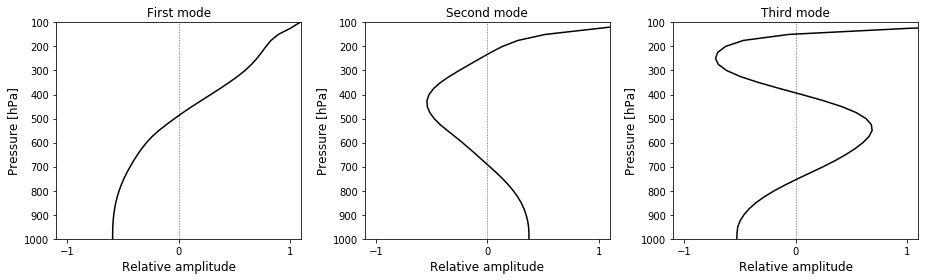

In [44]:
fig,ax = plt.subplots(1,3,figsize=(13,4))

for n in range(3):
    ax[n].plot(1/h[1,n+1]*h[:,n+1],p_r/100,'k')
    ax[n].set_ylim([1000,100]);ax[n].set_xlim([-1.1,1.1])
    ax[n].vlines(x=0,ymin=100,ymax=1000,linewidth=0.6,linestyle=':')
    ax[n].set_xticks([-1,0,1])
    ax[n].set_ylabel('Pressure [hPa]',fontsize=12)
    ax[n].set_xlabel('Relative amplitude',fontsize=12)
    ax[0].set_title('First mode');ax[1].set_title('Second mode');ax[2].set_title('Third mode');            
plt.tight_layout()

#### These vertical modes are eigenfuctions of geopotential height, horizontal wind, momentum forcing and heating divergence (see eq. 5-8 in Haertel et al., 2014). Now we can use the hydrostatic equation $\frac{\partial \phi}{\partial t} = -\frac{RT}{p}$ to derive the corresponding structures of temperature, and $D=\frac{\partial}{\partial p}(\frac{Q}{S})$ for Q, purturbation heating.

In [12]:
# vertical modes for state variables, T,Q and phi, v, div in the shallow water equation
T_m = -np.tile(p_r,(3,1)).swapaxes(0,1)*np.gradient(h[:,1:4],p_r,axis=0)/R # dphi/dp = -RT/p
T_m[0,:] = 0; T_m[-1,:]= 0 # rigid boundaries

A_m = np.copy(T_m); A_m[0,:] = 0
for k in range(1,len(p_r)-1):
    A_m[k,:] = np.asarray([np.trapz(h[:k+1,n],p_r[:k+1]) for n in range(1,4)])
A_m[-1,:] = 0
Q_m = np.asarray([A_m[:,n]*S_r for n in range(3)]).swapaxes(0,1)

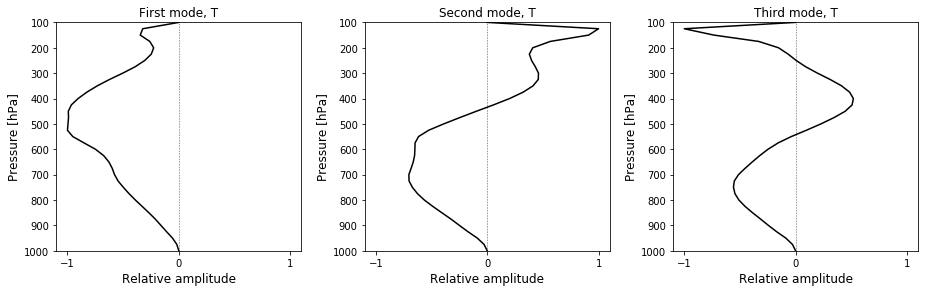

In [21]:
ax1 = vmode_plot(T_m)
ax1[0].set_title('First mode, T')
ax1[1].set_title('Second mode, T')
ax1[2].set_title('Third mode, T')
plt.show()

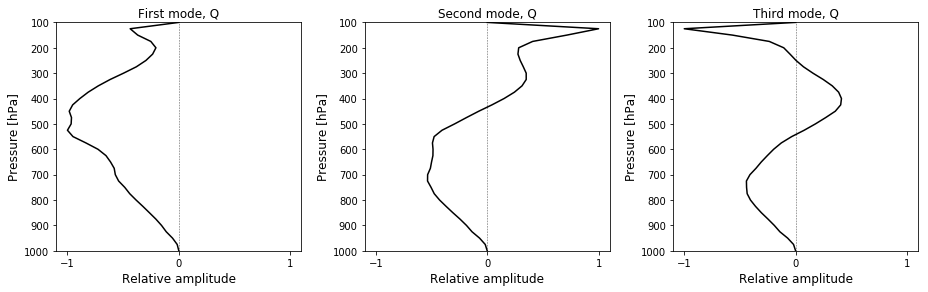

In [22]:
ax1 = vmode_plot(Q_m)
ax1[0].set_title('First mode, Q')
ax1[1].set_title('Second mode, Q')
ax1[2].set_title('Third mode, Q')
plt.show()

Normolized vertical modes of T and Q are quite identical.

### 2. Gravity phase speed: C$_0$ = $\sqrt{gH_e}$
According to the equation set, the obatianed eigenvalues, $\lambda$, are positive definite and C0 = 1/$\sqrt\lambda$

In [15]:
c0 = 1/np.sqrt(-L[1:4]) # phase speed of each mode [m/s] 
He = c0**2/9.8 # equivalent depth [m]
print(c0, He)

[53.01629054 26.48595664 19.87032932] [286.8088839   71.5822346   40.28877421]


### 3. Vertical structures for first three modes: projection of mode into data